In [1]:
import platform
import cpuinfo
import psutil
import GPUtil


def display_sys_info():
    print("System")
    print(f"  OS: {platform.system()} {platform.version()}")


def display_cpu_info():
    info = cpuinfo.get_cpu_info()
    virtual_memory = psutil.virtual_memory()
    print("\nCPU")
    print(f"  CPU: {info['brand_raw']}")
    print(f"  Architecture: {info['arch']}")
    print(f"  CPU Count: {info['count']}")
    print(f"  CPU Speed: {info['hz_actual_friendly']}")
    print(f"  Memory Total: {virtual_memory.total / (1024 ** 3):.2f} GB")


def display_gpu_info():
    gpus = GPUtil.getGPUs()
    print("\nGPU:")
    print(f"  GPU count: {len(gpus)}")

    for gpu in gpus:
        memory_total_gb = gpu.memoryTotal / 1024
        memory_free_gb = gpu.memoryFree / 1024
        print(f"  Name: {gpu.name}, Memory Total: {memory_total_gb:.2f} GB, Memory Free: {memory_free_gb:.2f} GB")


display_sys_info()
display_cpu_info()
display_gpu_info()

ModuleNotFoundError: No module named 'cpuinfo'

In [2]:
import os
import pandas as pd

path = r'train'


folders = []
counts = []
category = []

for i, foldername in enumerate(os.listdir(path)):
    folderpath = os.path.join(path, foldername)
    count = 0
    for filename in os.listdir(folderpath):
        if filename.endswith('.JPG'):
            count += 1
        if filename.endswith('.jpg'):
            count += 1
    folders.append(foldername)
    counts.append(count)
    category.append(foldername.split('__')[0])

unique_category = list(set(category))
df = pd.DataFrame({ 'File Name': folders, 'Image Count': counts})

print(df)
print(f"Plant category: {unique_category}")

                                            File Name  Image Count
0                                  Apple___Apple_scab         1764
1                                   Apple___Black_rot         1738
2                            Apple___Cedar_apple_rust         1540
3                                     Apple___healthy         1757
4                                 Blueberry___healthy         1589
5            Cherry_(including_sour)___Powdery_mildew         1472
6                   Cherry_(including_sour)___healthy         1597
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...         1436
8                         Corn_(maize)___Common_rust_         1668
9                 Corn_(maize)___Northern_Leaf_Blight         1669
10                             Corn_(maize)___healthy         1626
11                                  Grape___Black_rot         1652
12                       Grape___Esca_(Black_Measles)         1680
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         

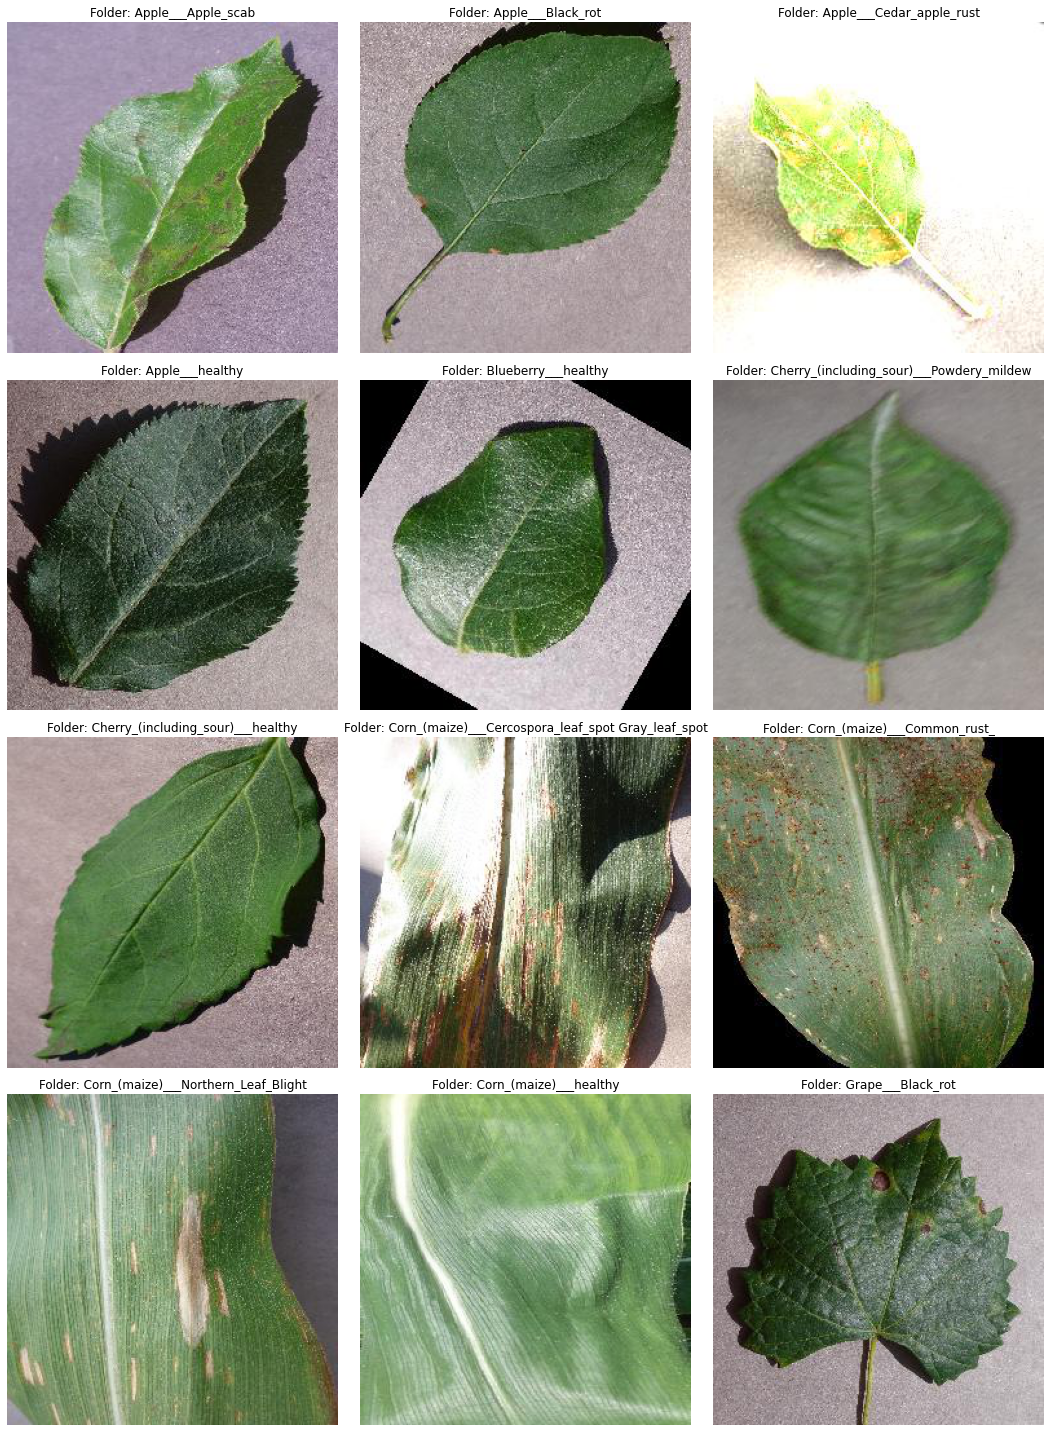

In [3]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path to your dataset
dataset_path = "train"

# Check if the path exists
if not os.path.exists(dataset_path):
    print("The specified dataset path does not exist. Please check the path.")
else:
    # List the first 12 subfolders
    subfolders = sorted([f.path for f in os.scandir(dataset_path) if f.is_dir()])[:12]

    # Initialize a figure for plotting
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # 4 rows, 3 columns

    for i, folder in enumerate(subfolders):
        images = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
        selected_image = random.choice(images)
        img = Image.open(selected_image)
        
        # Plotting the image
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Folder: {os.path.basename(folder)}")

    plt.tight_layout()
    plt.show()



In [5]:
import os
import dask
import dask.array as da
from skimage.io import imread
import numpy as np

# Function to read the image and convert it to an array of values
def load_image(file_path):
    # Use skimage or other libraries to read images
    img = imread(file_path)
    # Standardized images (0-1 range)
    return img / 255.0

# Function to get the path to all images
def get_image_paths(root_dir):
    image_paths = []
    for foldername in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, foldername)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith('.jpg'):
                    image_paths.append(os.path.join(folder_path, filename))
    return image_paths

root_dir = "train"
image_paths = get_image_paths(root_dir)

# Use the Dask delay operation to read pictures
lazy_arrays = [dask.delayed(load_image)(path) for path in image_paths]

# Get the size of the picture (assuming all pictures are the same size)
sample_img = imread(image_paths[0])
height, width, channels = sample_img.shape

# Create a Dask array
arrays = [da.from_delayed(lazy, shape=(height, width, channels), dtype=np.float32) for lazy in lazy_arrays]
dask_array = da.stack(arrays, axis=0)

# Calculate mean and std
mean = dask_array.mean(axis=(0, 1, 2)).compute()
std = dask_array.std(axis=(0, 1, 2)).compute()

print(f"Mean: {mean}, Std: {std}")



Mean: [0.47559854 0.50007176 0.42626825], Std: [0.2166402  0.19574274 0.23227517]


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Data set path
data_dir = "train"

# Converter: Only PIL images are converted to Tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 如果需要，调整图片尺寸
    transforms.ToTensor()
])

# Create an ImageFolder data set
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# Initializes the accumulator
mean = 0.
std = 0.
nb_samples = 0.

# Traverse the DataLoader
for data, _ in dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

# Finally, mean and std are calculated
mean /= nb_samples
std /= nb_samples

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.4756, 0.5001, 0.4263])
Std: tensor([0.1849, 0.1594, 0.2027])


In [5]:
pip install torch torchvision --user


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade typing_extensions


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


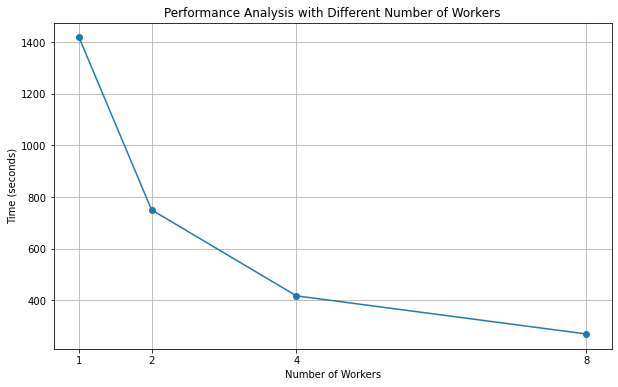

In [5]:
import os
import time
import dask
import dask.array as da
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

def load_image(file_path):
    img = imread(file_path)
    return img / 255.0

def get_image_paths(root_dir):
    image_paths = []
    if not os.path.exists(root_dir):
        print(f"Directory not found: {root_dir}")
        return image_paths

    for foldername in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, foldername)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith('.jpg'):
                    image_paths.append(os.path.join(folder_path, filename))
        else:
            print(f"Not a directory: {folder_path}")

    if not image_paths:
        print(f"No .jpg files found in {root_dir}")

    return image_paths


root_dir = "train"
image_paths = get_image_paths(root_dir)
sample_img = imread(image_paths[0])
height, width, channels = sample_img.shape

# 测试不同的 num_workers 设置
worker_settings = [1, 2, 4, 8]
times = []

for workers in worker_settings:
    dask.config.set(scheduler='processes', num_workers=workers)
    lazy_arrays = [dask.delayed(load_image)(path) for path in image_paths]
    arrays = [da.from_delayed(lazy, shape=(height, width, channels), dtype=np.float32) for lazy in lazy_arrays]
    dask_array = da.stack(arrays, axis=0)

    t0 = time.time()
    mean = dask_array.mean(axis=(0, 1, 2)).compute()
    std = dask_array.std(axis=(0, 1, 2)).compute()
    time_elapsed = time.time() - t0
    print("num_workers is",workers,",time is", time_elapsed)
    times.append(time_elapsed)

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(worker_settings, times, marker='o')
plt.title('Performance Analysis with Different Number of Workers')
plt.xlabel('Number of Workers')
plt.ylabel('Time (seconds)')
plt.xticks(worker_settings)
plt.grid(True)
plt.show()


Workers: 1, Time: 255.66603136062622 seconds, Mean: tensor([0.4756, 0.5001, 0.4263]), Std: tensor([0.1849, 0.1594, 0.2027])
Workers: 2, Time: 134.14306092262268 seconds, Mean: tensor([0.4756, 0.5001, 0.4263]), Std: tensor([0.1849, 0.1594, 0.2027])
Workers: 4, Time: 88.39931178092957 seconds, Mean: tensor([0.4756, 0.5001, 0.4263]), Std: tensor([0.1849, 0.1594, 0.2027])
Workers: 8, Time: 69.51494097709656 seconds, Mean: tensor([0.4756, 0.5001, 0.4263]), Std: tensor([0.1849, 0.1594, 0.2027])


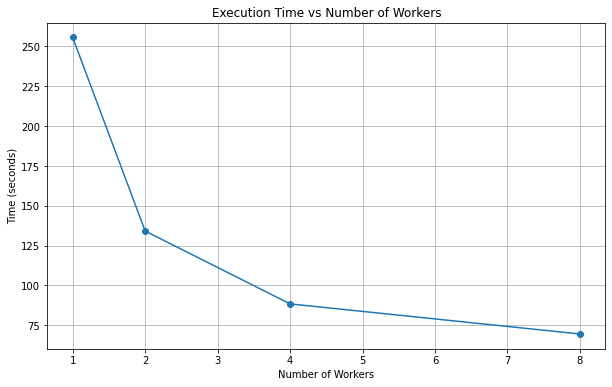

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

# Function to calculate mean and standard deviation
def calculate_mean_std(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.

    for data, _ in data_loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std

# Dataset paths and converters
data_dir = "train"
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Test different number of workers
worker_counts = [1, 2, 4, 8]
times = []

for num_workers in worker_counts:
    # Create a dataset
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=num_workers)

    # Record time and calculate mean and standard deviation
    start_time = time.time()
    mean, std = calculate_mean_std(data_loader)
    end_time = time.time()

    # Record the time spent
    times.append(end_time - start_time)

    print(f"Workers: {num_workers}, Time: {end_time - start_time} seconds, Mean: {mean}, Std: {std}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(worker_counts, times, marker='o')
plt.title("Execution Time vs Number of Workers")
plt.xlabel("Number of Workers")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()
